# **ENGLISH TO INDIC**

In [ ]:
!pip install tensorflow==2.14.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!git clone https://github.com/AI4Bharat/IndicTrans2.git

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder

In [ ]:
%%capture
%cd /content/IndicTrans2/huggingface_interface

In [ ]:
%%capture
!python3 -m pip install nltk sacremoses pandas regex mock transformers>=4.33.2 mosestokenizer
!python3 -c "import nltk; nltk.download('punkt')"
!python3 -m pip install bitsandbytes scipy accelerate datasets
!python3 -m pip install sentencepiece

!git clone https://github.com/VarunGumma/IndicTransTokenizer
%cd IndicTransTokenizer
!python3 -m pip install --editable ./
%cd ..

In [ ]:
ENCODER_LEN = 100
DECODER_LEN = 100
BATCH_SIZE = 32
BUFFER_SIZE = BATCH_SIZE*4

In [ ]:
# Load each dataset
train_df_nepali = pd.read_csv("/content/drive/MyDrive/dataset/nepali.csv")
train_df_assamese = pd.read_csv("/content/drive/MyDrive/dataset/assamese.csv")
train_df_bodo = pd.read_csv("/content/drive/MyDrive/dataset/bodo.csv")
train_df_khasi = pd.read_csv("/content/drive/MyDrive/dataset/khasi.csv")
train_df_manipuri = pd.read_csv("/content/drive/MyDrive/dataset/manipuri.csv")
train_df_mizo = pd.read_csv("/content/drive/MyDrive/dataset/mizo.csv")



In [ ]:
train_df_assamese.drop_duplicates()
train_df_bodo.drop_duplicates()
train_df_nepali.drop_duplicates()
train_df_mizo.drop_duplicates()
train_df_khasi.drop_duplicates()
train_df_manipuri.drop_duplicates()

,ENGLISH,MANIPURI
0,Alison Masturbate Give Me Emotions 12: 00\n,একাকী হটি এলিসন হস্তমৈথুন Give Me আবেগ 12:00\n
1,"Social Security, Social Security, and Social S...",ওল পোৎ পিবা থবক থিবা বিলস শকখঙচেশিং সোশ্যাল সি...
2,"Late Nrityashilpi Amalashankar, Chief Minister...","প্রয়াত নৃত্যশিল্পী অমলাশঙ্কর, মুখ্যমন্ত্রীর শ..."
3,Teri Ha Papdi has a fire cracker in it.\n,তেরি হা পাপদি দা মৈ ক্রেতা আ\n
4,But that doesn't mean we can't.\n,অদুবু মসিনা ঐখোয় য়ারে পেল্লে হায়বা য়াদ্রি।\n
...,...,...
60225,"Taxes and levies not refundable and duties, ce...",তেক্সশিং অমসুং লেবিসশিং রিফন্দ তৌদ্রিবা অমসুং ...
60226,b. at least two people\n,3. n য়ামদ্রবদা মী অনী খূৎ থাদুনা খৎনবা\n
60227,These rankings are made after evaluating the b...,অওনবশিংনা পুরকপা কান্নবশিং য়েংলবা মতুংদা হায়...
60228,Mera teri gali mein - Jeena teri gali mein.\n,মরনা তেরী গলী মেঁ - জীনা তেরী গলী মেঁ।\n


In [ ]:

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ENGLISH' column
train_df_nepali['ENGLISH'] = train_df_nepali['ENGLISH'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'बड़ो' column
train_df_nepali['NEPALI'] = train_df_nepali['NEPALI'].apply(lambda x: re.sub(r'[^a-zA-Z\u0900-\u097F\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ENGLISH' column
train_df_nepali['ENGLISH'] = train_df_nepali['ENGLISH'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove punctuation for the 'बड़ो' column
train_df_nepali['NEPALI'] = train_df_nepali['NEPALI'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ENGLISH' column
train_df_nepali['ENGLISH'] = train_df_nepali['ENGLISH'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove extra whitespace for the 'बड़ो' column
train_df_nepali['NEPALI'] = train_df_nepali['NEPALI'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove rows with empty values
train_df_nepali.replace('', np.nan, inplace=True)
train_df_nepali.dropna(subset=['ENGLISH', 'NEPALI'], inplace=True)

# Save the cleaned Nepali data to a new CSV file
train_df_nepali.to_csv('nepali.csv', columns=['ENGLISH', 'NEPALI'], index=False)

In [ ]:
def clean_manipuri_text(text):
    # Replace characters not in the Manipuri script with a space
    cleaned_text = re.sub(r'[^\u0980-\u09FF\s]', ' ', str(text).lower()) if pd.notnull(text) else ''
    # Remove extra whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text.strip())
    return cleaned_text
# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ENGLISH' column
train_df_manipuri['ENGLISH'] = train_df_manipuri['ENGLISH'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ENGLISH' column
train_df_manipuri['ENGLISH'] = train_df_manipuri['ENGLISH'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ENGLISH' column
train_df_manipuri['ENGLISH'] = train_df_manipuri['ENGLISH'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Apply the cleaning function to the 'MANIPURI' column
train_df_manipuri['MANIPURI'] = train_df_manipuri['MANIPURI'].apply(clean_manipuri_text)

# Remove punctuation for the 'MANIPURI' column
train_df_manipuri['MANIPURI'] = train_df_manipuri['MANIPURI'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove rows with empty values
train_df_manipuri.replace('', np.nan, inplace=True)
train_df_manipuri.dropna(subset=['ENGLISH', 'MANIPURI'], inplace=True)

# Save the cleaned Manipuri data to a new CSV file
train_df_manipuri.to_csv('manipuri.csv', columns=['ENGLISH', 'MANIPURI'], index=False)

# Display the cleaned DataFrame
print(train_df_manipuri[['ENGLISH', 'MANIPURI']])

                                                 ENGLISH  \
0                     alison masturbate give me emotions   
1      social security social security and social sec...   
2      late nrityashilpi amalashankar chief ministers...   
3                 teri ha papdi has a fire cracker in it   
4                           but that doesnt mean we cant   
...                                                  ...   
60225  taxes and levies not refundable and duties ces...   
60226                              b at least two people   
60227  these rankings are made after evaluating the b...   
60228           mera teri gali mein jeena teri gali mein   
60229                                         on july in   

                                                MANIPURI  
0                         একাকী হটি এলিসন হস্তমৈথুন আবেগ  
1      ওল পোৎ পিবা থবক থিবা বিলস শকখঙচেশিং সোশ্যাল সি...  
2      প্রয়াত নৃত্যশিল্পী অমলাশঙ্কর মুখ্যমন্ত্রীর শো...  
3                           তেরি হা পাপদি দ

In [ ]:
import re
import string
import pandas as pd
import numpy as np

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ENGLISH' column
train_df_assamese['ENGLISH'] = train_df_assamese['ENGLISH'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ENGLISH' column
train_df_assamese['ENGLISH'] = train_df_assamese['ENGLISH'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ENGLISH' column
train_df_assamese['ENGLISH'] = train_df_assamese['ENGLISH'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ASSAMESE' column
train_df_assamese['ASSAMESE'] = train_df_assamese['ASSAMESE'].apply(lambda x: re.sub(r'[^a-zA-Z\u0980-\u09FF\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ASSAMESE' column
train_df_assamese['ASSAMESE'] = train_df_assamese['ASSAMESE'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ASSAMESE' column
train_df_assamese['ASSAMESE'] = train_df_assamese['ASSAMESE'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove rows with empty values
train_df_assamese.replace('', np.nan, inplace=True)
train_df_assamese.dropna(subset=['ENGLISH', 'ASSAMESE'], inplace=True)

# Save the cleaned Assamese data to a new CSV file
train_df_assamese.to_csv('assamese.csv', columns=['ENGLISH', 'ASSAMESE'], index=False)

# Display the cleaned DataFrame
print(train_df_assamese[['ENGLISH','ASSAMESE']])


                                                  ENGLISH  \
0                                        tie up long hair   
1       nevertheless he gave this assurance he that ha...   
2       david wrote many things you yourself have done...   
3       to many people today a martyr is more or less ...   
4       after protests were conducted over the decisio...   
...                                                   ...   
141228                                        what is god   
141229     jehovahs feelings toward the haughty are clear   
141230  as we approach the end of this system of thing...   
141231  what can be said about the religious situation...   
141232  i won my battle with postpartum depression awa...   

                                                 ASSAMESE  
0                                     মেলি থোৱা দীঘল চুলি  
1       যিয়েই নহওঁক যিসকলে এই কাৰ্য্য প্ৰাণপণে কৰা চেষ...  
2       ইয়োব ৩৮ ৪ ৬ পদত উল্লেখ কৰা লিখনীৰ পৰা আমি কি জ...  
3       এই সন্দৰ্ভত তেওঁ পী

In [ ]:
# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ENGLISH' column
train_df_khasi['ENGLISH'] = train_df_khasi['ENGLISH'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'KHASI_DEVA' column
train_df_khasi['KHASI'] = train_df_khasi['KHASI'].apply(lambda x: re.sub(r'[^a-zA-Z\u0900-\u097F\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ENGLISH' column
train_df_khasi['ENGLISH'] = train_df_khasi['ENGLISH'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove punctuation for the 'KHASI' column
train_df_khasi['KHASI'] = train_df_khasi['KHASI'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ENGLISH' column
train_df_khasi['ENGLISH'] = train_df_khasi['ENGLISH'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove extra whitespace for the 'KHASI' column
train_df_khasi['KHASI'] = train_df_khasi['KHASI'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove rows with empty values
train_df_khasi.replace('', np.nan, inplace=True)
train_df_khasi.dropna(subset=['ENGLISH', 'KHASI'], inplace=True)

# Save the cleaned Khasi data to a new CSV file
train_df_khasi.to_csv('khasi.csv', columns=['ENGLISH', 'KHASI'], index=False)

In [ ]:
# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ENGLISH' column
train_df_mizo['ENGLISH'] = train_df_mizo['ENGLISH'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'MIZO_DEVA' column
train_df_mizo['MIZO'] = train_df_mizo['MIZO'].apply(lambda x: re.sub(r'[^a-zA-Z\u0900-\u097F\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ENGLISH' column
train_df_mizo['ENGLISH'] = train_df_mizo['ENGLISH'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove punctuation for the 'MIZO' column
train_df_mizo['MIZO'] = train_df_mizo['MIZO'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ENGLISH' column
train_df_mizo['ENGLISH'] = train_df_mizo['ENGLISH'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove extra whitespace for the 'MIZO' column
train_df_mizo['MIZO'] = train_df_mizo['MIZO'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove rows with empty values
train_df_mizo.replace('', np.nan, inplace=True)
train_df_mizo.dropna(subset=['ENGLISH', 'MIZO'], inplace=True)

# Save the cleaned Mizo data to a new CSV file
train_df_mizo.to_csv('mizo.csv', columns=['ENGLISH', 'MIZO'], index=False)


In [ ]:

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ENGLISH' column
train_df_bodo['ENGLISH'] = train_df_bodo['ENGLISH'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'BODO_DEVA' column
train_df_bodo['BODO'] = train_df_bodo['BODO'].apply(lambda x: re.sub(r'[^a-zA-Z\u0900-\u097F\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ENGLISH' column
train_df_bodo['ENGLISH'] = train_df_bodo['ENGLISH'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove punctuation for the 'BODO' column
train_df_bodo['BODO'] = train_df_bodo['BODO'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ENGLISH' column
train_df_bodo['ENGLISH'] = train_df_bodo['ENGLISH'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove extra whitespace for the 'BODO' column
train_df_bodo['BODO'] = train_df_bodo['BODO'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove rows with empty values
train_df_bodo.replace('', np.nan, inplace=True)
train_df_bodo.dropna(subset=['ENGLISH', 'BODO'], inplace=True)

# Save the cleaned Bodo data to a new CSV file
train_df_bodo.to_csv('bodo.csv', columns=['ENGLISH', 'BODO'], index=False)


In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
# Split the English to Bodo dataset into training, testing, and validation sets
train_data_bodo, temp_data_bodo = train_test_split(train_df_bodo, test_size=0.3, random_state=42)
val_data_bodo, test_data_bodo = train_test_split(temp_data_bodo, test_size=0.17, random_state=42)  # 0.17 * (0.7 / 0.3) = 0.15

# Save the training, validation, and testing data to separate CSV files for Bodo
train_data_bodo.to_csv('trbodo.csv', columns=['ENGLISH', 'BODO'], index=False)
val_data_bodo.to_csv('vbodo.csv', columns=['ENGLISH', 'BODO'], index=False)
test_data_bodo.to_csv('tsbodo.csv', columns=['ENGLISH', 'BODO'], index=False)

# Split the English to Nepali dataset into training, testing, and validation sets
train_data_nepali, temp_data_nepali = train_test_split(train_df_nepali, test_size=0.3, random_state=42)
val_data_nepali, test_data_nepali = train_test_split(temp_data_nepali, test_size=0.17, random_state=42)  # 0.17 * (0.7 / 0.3) = 0.15

# Save the training, validation, and testing data to separate CSV files for Nepali
train_data_nepali.to_csv('trnepali.csv', columns=['ENGLISH', 'NEPALI'], index=False)
val_data_nepali.to_csv('vnepali.csv', columns=['ENGLISH', 'NEPALI'], index=False)
test_data_nepali.to_csv('tenepali.csv', columns=['ENGLISH', 'NEPALI'], index=False)

# Split the English to Khasi dataset into training, testing, and validation sets
train_data_khasi, temp_data_khasi = train_test_split(train_df_khasi, test_size=0.3, random_state=42)
val_data_khasi, test_data_khasi = train_test_split(temp_data_khasi, test_size=0.17, random_state=42)  # 0.17 * (0.7 / 0.3) = 0.15

# Save the training, validation, and testing data to separate CSV files for Khasi
train_data_khasi.to_csv('trkhasi.csv', columns=['ENGLISH', 'KHASI'], index=False)
val_data_khasi.to_csv('vkhasi.csv', columns=['ENGLISH', 'KHASI'], index=False)
test_data_khasi.to_csv('tkhasi.csv', columns=['ENGLISH', 'KHASI'], index=False)

# Split the English to Manipuri dataset into training, testing, and validation sets
train_data_manipuri, temp_data_manipuri = train_test_split(train_df_manipuri, test_size=0.3, random_state=42)
val_data_manipuri, test_data_manipuri = train_test_split(temp_data_manipuri, test_size=0.17, random_state=42)  # 0.17 * (0.7 / 0.3) = 0.15

# Save the training, validation, and testing data to separate CSV files for Manipuri
train_data_manipuri.to_csv('trmanipuri.csv', columns=['ENGLISH', 'MANIPURI'], index=False)
val_data_manipuri.to_csv('vmanipuri.csv', columns=['ENGLISH', 'MANIPURI'], index=False)
test_data_manipuri.to_csv('tmanipuri.csv', columns=['ENGLISH', 'MANIPURI'], index=False)

# Split the English to Mizo dataset into training, testing, and validation sets
train_data_mizo, temp_data_mizo = train_test_split(train_df_mizo, test_size=0.3, random_state=42)
val_data_mizo, test_data_mizo = train_test_split(temp_data_mizo, test_size=0.17, random_state=42)  # 0.17 * (0.7 / 0.3) = 0.15

# Save the training, validation, and testing data to separate CSV files for Mizo
train_data_mizo.to_csv('trmizo.csv', columns=['ENGLISH', 'MIZO'], index=False)
val_data_mizo.to_csv('vmizo.csv', columns=['ENGLISH', 'MIZO'], index=False)
test_data_mizo.to_csv('tmizo.csv', columns=['ENGLISH', 'MIZO'], index=False)

# Split the English to Assamese dataset into training, testing, and validation sets
train_data_assamese, temp_data_assamese = train_test_split(train_df_assamese, test_size=0.3, random_state=42)
val_data_assamese, test_data_assamese = train_test_split(temp_data_assamese, test_size=0.17, random_state=42)  # 0.17 * (0.7 / 0.3) = 0.15

# Save the training, validation, and testing data to separate CSV files for Assamese
train_data_assamese.to_csv('trassamese.csv', columns=['ENGLISH', 'ASSAMESE'], index=False)
val_data_assamese.to_csv('vassamese.csv', columns=['ENGLISH', 'ASSAMESE'], index=False)
test_data_assamese.to_csv('tassamese.csv', columns=['ENGLISH', 'ASSAMESE'], index=False)


In [ ]:
# Separate English to Bodo dataset
eng_b = train_df_bodo['ENGLISH']
brx = train_df_bodo['BODO']

# Separate English to Nepali dataset
eng_n = train_df_nepali['ENGLISH']
npi = train_df_nepali['NEPALI']

# Separate English to Khasi dataset
eng_khasi = train_df_khasi['ENGLISH']
khasi = train_df_khasi['KHASI']

# Separate English to Manipuri dataset
eng_manipuri = train_df_manipuri['ENGLISH']
manipuri = train_df_manipuri['MANIPURI']

# Separate English to Mizo dataset
eng_mizo = train_df_mizo['ENGLISH']
mizo = train_df_mizo['MIZO']

# Separate English to Assamese dataset
eng_assamese = train_df_assamese['ENGLISH']
assamese = train_df_assamese['ASSAMESE']


In [ ]:
eng_b = eng_b.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
brx = brx.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

# Use correct variable names in tokenizers
eng_b_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
brx_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
eng_b_tokenizer.fit_on_texts(eng_b)
brx_tokenizer.fit_on_texts(brx)
inputs_bodo = eng_b_tokenizer.texts_to_sequences(eng_b)
targets_bodo = brx_tokenizer.texts_to_sequences(brx)

# Print tokenizers
print(eng_b_tokenizer)
print(brx_tokenizer)

In [ ]:
eng_n = eng_n.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
npi = npi.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

# Use correct variable names in tokenizers
eng_n_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
npi_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
eng_n_tokenizer.fit_on_texts(eng_n)
npi_tokenizer.fit_on_texts(npi)
inputs_nepali = eng_b_tokenizer.texts_to_sequences(eng_n)
targets_nepali = brx_tokenizer.texts_to_sequences(npi)

# Print tokenizers
print(eng_n_tokenizer)
print(npi_tokenizer)



In [ ]:
# Preprocess Khasi dataset
eng_khasi = eng_khasi.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
khasi = khasi.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
eng_khasi_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
khasi_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
eng_khasi_tokenizer.fit_on_texts(eng_khasi)
khasi_tokenizer.fit_on_texts(khasi)
inputs_khasi = eng_khasi_tokenizer.texts_to_sequences(eng_khasi)
targets_khasi = khasi_tokenizer.texts_to_sequences(khasi)

# Print tokenizers for Khasi
print(eng_khasi_tokenizer)
print(khasi_tokenizer)

# Preprocess Manipuri dataset
eng_manipuri = eng_manipuri.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
manipuri = manipuri.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
eng_manipuri_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
manipuri_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
eng_manipuri_tokenizer.fit_on_texts(eng_manipuri)
manipuri_tokenizer.fit_on_texts(manipuri)
inputs_manipuri = eng_manipuri_tokenizer.texts_to_sequences(eng_manipuri)
targets_manipuri = manipuri_tokenizer.texts_to_sequences(manipuri)

# Print tokenizers for Manipuri
print(eng_manipuri_tokenizer)
print(manipuri_tokenizer)

# Preprocess Mizo dataset
eng_mizo = eng_mizo.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
mizo = mizo.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
eng_mizo_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
mizo_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
eng_mizo_tokenizer.fit_on_texts(eng_mizo)
mizo_tokenizer.fit_on_texts(mizo)
inputs_mizo = eng_mizo_tokenizer.texts_to_sequences(eng_mizo)
targets_mizo = mizo_tokenizer.texts_to_sequences(mizo)

# Print tokenizers for Mizo
print(eng_mizo_tokenizer)
print(mizo_tokenizer)

# Preprocess Assamese dataset
eng_assamese = eng_assamese.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
assamese = assamese.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
eng_assamese_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
assamese_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
eng_assamese_tokenizer.fit_on_texts(eng_assamese)
assamese_tokenizer.fit_on_texts(assamese)
inputs_assamese = eng_assamese_tokenizer.texts_to_sequences(eng_assamese)
targets_assamese = assamese_tokenizer.texts_to_sequences(assamese)

# Print tokenizers for Assamese
print(eng_assamese_tokenizer)
print(assamese_tokenizer)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Collect all English texts from the different datasets
all_eng_texts = pd.concat([eng_b, eng_n, eng_khasi, eng_manipuri, eng_mizo, eng_assamese], ignore_index=True)

# Create a new tokenizer and fit it on the combined English texts
merged_eng_tokenizer = Tokenizer(filters=filters, oov_token=oov_token)
merged_eng_tokenizer.fit_on_texts(all_eng_texts)

# Print the merged English tokenizer
print(merged_eng_tokenizer)

# Optionally, save the tokenizer if needed
import pickle
with open('merged_eng_tokenizer.pkl', 'wb') as f:
    pickle.dump(merged_eng_tokenizer, f)


In [ ]:
ENCODER_VOCAB = len(merged_eng_tokenizer.word_index) + 1
DECODER_B_VOCAB = len(brx_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_B_VOCAB)

130870 200240


In [ ]:

DECODER_A_VOCAB = len(assamese_tokenizer.word_index) + 1
DECODER_B_VOCAB = len(brx_tokenizer.word_index) + 1
DECODER_N_VOCAB = len(npi_tokenizer.word_index) + 1
DECODER_K_VOCAB = len(khasi_tokenizer.word_index) + 1
DECODER_MI_VOCAB = len(mizo_tokenizer.word_index) + 1
DECODER_MA_VOCAB = len(manipuri_tokenizer.word_index) + 1


In [ ]:

# Calculate max lengths among sequences
max_length_bodo_encoder = max(len(seq) for seq in inputs_bodo)
max_length_bodo_decoder = max(len(seq) for seq in targets_bodo)


# Calculate max lengths among sequences
max_length_nepali_encoder = max(len(seq) for seq in inputs_nepali)
max_length_nepali_decoder = max(len(seq) for seq in targets_nepali)


In [ ]:
# Calculate max lengths among sequences for all languages

# Bodo
max_length_bodo_encoder = max(len(seq) for seq in inputs_bodo)

# Nepali
max_length_nepali_encoder = max(len(seq) for seq in inputs_nepali)

# Khasi
max_length_khasi_encoder = max(len(seq) for seq in inputs_khasi)

# Manipuri
max_length_manipuri_encoder = max(len(seq) for seq in inputs_manipuri)

# Mizo
max_length_mizo_encoder = max(len(seq) for seq in inputs_mizo)

# Assamese
max_length_assamese_encoder = max(len(seq) for seq in inputs_assamese)

# Find the overall maximum length for the shared encoder
max_length_encoder = max(
    max_length_bodo_encoder,
    max_length_nepali_encoder,
    max_length_khasi_encoder,
    max_length_manipuri_encoder,
    max_length_mizo_encoder,
    max_length_assamese_encoder
)

# Print maximum lengths for the shared encoder
print("Max length for shared encoder:", max_length_encoder)

# Calculate max lengths among sequences for decoders
# Bodo
max_length_bodo_decoder = max(len(seq) for seq in targets_bodo)
# Nepali
max_length_nepali_decoder = max(len(seq) for seq in targets_nepali)
# Khasi
max_length_khasi_decoder = max(len(seq) for seq in targets_khasi)
# Manipuri
max_length_manipuri_decoder = max(len(seq) for seq in targets_manipuri)
# Mizo
max_length_mizo_decoder = max(len(seq) for seq in targets_mizo)
# Assamese
max_length_assamese_decoder = max(len(seq) for seq in targets_assamese)

# Find the overall maximum length for the decoders
max_length_decoder = max(
    max_length_bodo_decoder,
    max_length_nepali_decoder,
    max_length_khasi_decoder,
    max_length_manipuri_decoder,
    max_length_mizo_decoder,
    max_length_assamese_decoder
)

# Print maximum lengths for the decoders
print("Max length for all decoders:", max_length_decoder)


Max length for shared encoder: 1062
Max length for all decoders: 1541


In [ ]:
import tensorflow as tf

# Pad sequences to a common length for each language
def pad_and_convert(inputs, targets, max_length_encoder, max_length_decoder):
    inputs_padded = tf.keras.preprocessing.sequence.pad_sequences(
        inputs, maxlen=max_length_encoder, padding='post', truncating='post'
    )
    targets_padded = tf.keras.preprocessing.sequence.pad_sequences(
        targets, maxlen=max_length_decoder, padding='post', truncating='post'
    )
    inputs_tensor = tf.convert_to_tensor(inputs_padded)
    targets_tensor = tf.convert_to_tensor(targets_padded)
    return inputs_tensor, targets_tensor

# Example for Nepali
inputs_nepali, targets_nepali = pad_and_convert(inputs_nepali, targets_nepali, max_length_nepali_encoder, max_length_nepali_decoder)

# Similarly, pad and convert for Bodo
inputs_bodo, targets_bodo = pad_and_convert(inputs_bodo, targets_bodo, max_length_encoder, max_length_bodo_decoder)

# Similarly, pad and convert for Khasi
inputs_khasi, targets_khasi = pad_and_convert(inputs_khasi, targets_khasi, max_length_encoder, max_length_khasi_decoder)

# Similarly, pad and convert for Manipuri
inputs_manipuri, targets_manipuri = pad_and_convert(inputs_manipuri, targets_manipuri, max_length_encoder, max_length_manipuri_decoder)

# Similarly, pad and convert for Mizo
inputs_mizo, targets_mizo = pad_and_convert(inputs_mizo, targets_mizo, max_length_encoder, max_length_mizo_decoder)

# Similarly, pad and convert for Assamese
inputs_assamese, targets_assamese = pad_and_convert(inputs_assamese, targets_assamese, max_length_encoder, max_length_assamese_decoder)


In [ ]:
print(inputs_bodo)
print(targets_bodo)
print(inputs_nepali)
print(targets_nepali)
print("Inputs Khasi:", inputs_khasi)
print("Targets Khasi:", targets_khasi)
print("Inputs Manipuri:", inputs_manipuri)
print("Targets Manipuri:", targets_manipuri)
print("Inputs Mizo:", inputs_mizo)
print("Targets Mizo:", targets_mizo)
print("Inputs Assamese:", inputs_assamese)
print("Targets Assamese:", targets_assamese)

tf.Tensor(
[[    3   206   765 ...     0     0     0]
 [    3   300   106 ...     0     0     0]
 [    3   619  2024 ...     0     0     0]
 ...
 [    3 65871  1844 ...     0     0     0]
 [    3 65872  1759 ...     0     0     0]
 [    3  5907 18842 ...     0     0     0]], shape=(116906, 1062), dtype=int32)
tf.Tensor(
[[     2    228   9381 ...      0      0      0]
 [     2      6    254 ...      0      0      0]
 [     2    943      7 ...      0      0      0]
 ...
 [     2 200234   3267 ...      0      0      0]
 [     2 200236   3056 ...      0      0      0]
 [     2  28110  75403 ...      0      0      0]], shape=(116906, 125), dtype=int32)
tf.Tensor(
[[   3   13 1438 ...    0    0    0]
 [   3   13 1438 ...    0    0    0]
 [   3 6682  179 ...    0    0    0]
 ...
 [   3 1671    2 ...    0    0    0]
 [   3 2092  672 ...    0    0    0]
 [   3 3071    2 ...    0    0    0]], shape=(151810, 500), dtype=int32)
tf.Tensor(
[[     2      1      1 ...      0      0      0]
 [     2 

In [ ]:
# Create a dataset for English to Bodo
bodo_dataset = tf.data.Dataset.from_tensor_slices((inputs_bodo, targets_bodo, np.ones_like(inputs_bodo))).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create a dataset for English to Nepali
nepali_dataset = tf.data.Dataset.from_tensor_slices((inputs_nepali, targets_nepali, np.ones_like(inputs_nepali) * 2)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create a dataset for English to Khasi
khasi_dataset = tf.data.Dataset.from_tensor_slices((inputs_khasi, targets_khasi, np.ones_like(inputs_khasi) * 3)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create a dataset for English to Manipuri
manipuri_dataset = tf.data.Dataset.from_tensor_slices((inputs_manipuri, targets_manipuri, np.ones_like(inputs_manipuri) * 4)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create a dataset for English to Mizo
mizo_dataset = tf.data.Dataset.from_tensor_slices((inputs_mizo, targets_mizo, np.ones_like(inputs_mizo) * 5)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create a dataset for English to Assamese
assamese_dataset = tf.data.Dataset.from_tensor_slices((inputs_assamese, targets_assamese, np.ones_like(inputs_assamese) * 6)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def get_angles(position, i, d_model, lang_id):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates + lang_id

def positional_encoding(position, d_model, lang_id):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model,
        lang_id
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)



def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask, lang_id):
        batch_size = tf.shape(q)[0]

        # Apply language-specific embeddings
        q = tf.concat([q, tf.one_hot(lang_id, depth=2)], axis=-1)
        k = tf.concat([k, tf.one_hot(lang_id, depth=2)], axis=-1)
        v = tf.concat([v, tf.one_hot(lang_id, depth=2)], axis=-1)

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        # Define multi-head attention layers for each language
        self.mha = {
            'bodo': MultiHeadAttention(d_model, num_heads),
            'nepali': MultiHeadAttention(d_model, num_heads),
            'khasi': MultiHeadAttention(d_model, num_heads),
            'manipuri': MultiHeadAttention(d_model, num_heads),
            'mizo': MultiHeadAttention(d_model, num_heads),
            'assamese': MultiHeadAttention(d_model, num_heads)
        }

        # Define feed-forward networks for each language
        self.ffn = {
            'bodo': point_wise_feed_forward_network(d_model, dff),
            'nepali': point_wise_feed_forward_network(d_model, dff),
            'khasi': point_wise_feed_forward_network(d_model, dff),
            'manipuri': point_wise_feed_forward_network(d_model, dff),
            'mizo': point_wise_feed_forward_network(d_model, dff),
            'assamese': point_wise_feed_forward_network(d_model, dff)
        }

        # Define layer normalization layers for each language
        self.layernorm1 = {
            'bodo': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'nepali': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'khasi': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'manipuri': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'mizo': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'assamese': tf.keras.layers.LayerNormalization(epsilon=1e-6)
        }
        self.layernorm2 = {
            'bodo': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'nepali': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'khasi': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'manipuri': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'mizo': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'assamese': tf.keras.layers.LayerNormalization(epsilon=1e-6)
        }

        # Define dropout layers
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, masks):
        outputs = {}

        # Process each language
        for lang in ['bodo', 'nepali', 'khasi', 'manipuri', 'mizo', 'assamese']:
            attn_output, _ = self.mha[lang](x[lang], x[lang], x[lang], masks[lang])
            attn_output = self.dropout1(attn_output, training=training)
            out1 = self.layernorm1[lang](x[lang] + attn_output)

            ffn_output = self.ffn[lang](out1)
            ffn_output = self.dropout2(ffn_output, training=training)
            outputs[lang] = self.layernorm2[lang](out1 + ffn_output)

        return outputs


In [ ]:
import tensorflow as tf

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        # Define MultiHeadAttention and feed-forward networks for each language
        self.mha1_bodo = MultiHeadAttention(d_model, num_heads)
        self.mha2_bodo = MultiHeadAttention(d_model, num_heads)
        self.ffn_bodo = point_wise_feed_forward_network(d_model, dff)

        self.mha1_nepali = MultiHeadAttention(d_model, num_heads)
        self.mha2_nepali = MultiHeadAttention(d_model, num_heads)
        self.ffn_nepali = point_wise_feed_forward_network(d_model, dff)

        self.mha1_khasi = MultiHeadAttention(d_model, num_heads)
        self.mha2_khasi = MultiHeadAttention(d_model, num_heads)
        self.ffn_khasi = point_wise_feed_forward_network(d_model, dff)

        self.mha1_manipuri = MultiHeadAttention(d_model, num_heads)
        self.mha2_manipuri = MultiHeadAttention(d_model, num_heads)
        self.ffn_manipuri = point_wise_feed_forward_network(d_model, dff)

        self.mha1_mizo = MultiHeadAttention(d_model, num_heads)
        self.mha2_mizo = MultiHeadAttention(d_model, num_heads)
        self.ffn_mizo = point_wise_feed_forward_network(d_model, dff)

        self.mha1_assamese = MultiHeadAttention(d_model, num_heads)
        self.mha2_assamese = MultiHeadAttention(d_model, num_heads)
        self.ffn_assamese = point_wise_feed_forward_network(d_model, dff)

        # Define LayerNormalization and Dropout layers for each language
        self.layernorm1_bodo = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2_bodo = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3_bodo = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.layernorm1_nepali = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2_nepali = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3_nepali = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.layernorm1_khasi = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2_khasi = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3_khasi = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.layernorm1_manipuri = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2_manipuri = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3_manipuri = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.layernorm1_mizo = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2_mizo = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3_mizo = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.layernorm1_assamese = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2_assamese = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3_assamese = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask, language):
        if language == 'bodo':
            mha1 = self.mha1_bodo
            mha2 = self.mha2_bodo
            ffn = self.ffn_bodo
            layernorm1 = self.layernorm1_bodo
            layernorm2 = self.layernorm2_bodo
            layernorm3 = self.layernorm3_bodo

        elif language == 'nepali':
            mha1 = self.mha1_nepali
            mha2 = self.mha2_nepali
            ffn = self.ffn_nepali
            layernorm1 = self.layernorm1_nepali
            layernorm2 = self.layernorm2_nepali
            layernorm3 = self.layernorm3_nepali

        elif language == 'khasi':
            mha1 = self.mha1_khasi
            mha2 = self.mha2_khasi
            ffn = self.ffn_khasi
            layernorm1 = self.layernorm1_khasi
            layernorm2 = self.layernorm2_khasi
            layernorm3 = self.layernorm3_khasi

        elif language == 'manipuri':
            mha1 = self.mha1_manipuri
            mha2 = self.mha2_manipuri
            ffn = self.ffn_manipuri
            layernorm1 = self.layernorm1_manipuri
            layernorm2 = self.layernorm2_manipuri
            layernorm3 = self.layernorm3_manipuri

        elif language == 'mizo':
            mha1 = self.mha1_mizo
            mha2 = self.mha2_mizo
            ffn = self.ffn_mizo
            layernorm1 = self.layernorm1_mizo
            layernorm2 = self.layernorm2_mizo
            layernorm3 = self.layernorm3_mizo

        elif language == 'assamese':
            mha1 = self.mha1_assamese
            mha2 = self.mha2_assamese
            ffn = self.ffn_assamese
            layernorm1 = self.layernorm1_assamese
            layernorm2 = self.layernorm2_assamese
            layernorm3 = self.layernorm3_assamese

        # Self-attention
        attn1, attn_weights_block1 = mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = layernorm1(attn1 + x)

        # Cross-attention
        attn2, attn_weights_block2 = mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = layernorm2(attn2 + out1)

        # Feed-forward network
        ffn_output = ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


In [ ]:
import tensorflow as tf

class SharedEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_english_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding_english = tf.keras.layers.Embedding(input_english_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x_english, training, mask_english):
        seq_len_english = tf.shape(x_english)[1]

        x_english = self.embedding_english(x_english)
        x_english *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x_english += self.pos_encoding[:, :seq_len_english, :]

        x_english = self.dropout(x_english, training=training)

        for i in range(self.num_layers):
            x_english = self.enc_layers[i](x_english, training, mask_english)

        return x_english


In [ ]:
class DecoderAssamese(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_assamese_vocab_size, maximum_position_encoding, rate=0.1):
        super(DecoderAssamese, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding_assamese = tf.keras.layers.Embedding(target_assamese_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers_assamese = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x_assamese, enc_output_english, training, look_ahead_mask_assamese, padding_mask_assamese):
        seq_len_assamese = tf.shape(x_assamese)[1]
        attention_weights_assamese = {}

        x_assamese = self.embedding_assamese(x_assamese)
        x_assamese *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x_assamese += self.pos_encoding[:, :seq_len_assamese, :]

        x_assamese = self.dropout(x_assamese, training=training)

        for i in range(self.num_layers):
            x_assamese, block1_assamese, block2_assamese = self.dec_layers_assamese[i](x_assamese, enc_output_english, training, look_ahead_mask_assamese, padding_mask_assamese)

            attention_weights_assamese[f'decoder_layer{i+1}_block1'] = block1_assamese
            attention_weights_assamese[f'decoder_layer{i+1}_block2'] = block2_assamese

        return x_assamese, attention_weights_assamese


In [ ]:
class DecoderBodo(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_bodo_vocab_size, maximum_position_encoding, rate=0.1):
        super(DecoderBodo, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding_bodo = tf.keras.layers.Embedding(target_bodo_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers_bodo = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x_bodo, enc_output_english, training, look_ahead_mask_bodo, padding_mask_bodo):
        seq_len_bodo = tf.shape(x_bodo)[1]
        attention_weights_bodo = {}

        x_bodo = self.embedding_bodo(x_bodo)
        x_bodo *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x_bodo += self.pos_encoding[:, :seq_len_bodo, :]

        x_bodo = self.dropout(x_bodo, training=training)

        for i in range(self.num_layers):
            x_bodo, block1_bodo, block2_bodo = self.dec_layers_bodo[i](x_bodo, enc_output_english, training, look_ahead_mask_bodo, padding_mask_bodo)

            attention_weights_bodo[f'decoder_layer{i+1}_block1'] = block1_bodo
            attention_weights_bodo[f'decoder_layer{i+1}_block2'] = block2_bodo

        return x_bodo, attention_weights_bodo


In [ ]:
class DecoderKhasi(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_khasi_vocab_size, maximum_position_encoding, rate=0.1):
        super(DecoderKhasi, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding_khasi = tf.keras.layers.Embedding(target_khasi_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers_khasi = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x_khasi, enc_output_english, training, look_ahead_mask_khasi, padding_mask_khasi):
        seq_len_khasi = tf.shape(x_khasi)[1]
        attention_weights_khasi = {}

        x_khasi = self.embedding_khasi(x_khasi)
        x_khasi *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x_khasi += self.pos_encoding[:, :seq_len_khasi, :]

        x_khasi = self.dropout(x_khasi, training=training)

        for i in range(self.num_layers):
            x_khasi, block1_khasi, block2_khasi = self.dec_layers_khasi[i](x_khasi, enc_output_english, training, look_ahead_mask_khasi, padding_mask_khasi)

            attention_weights_khasi[f'decoder_layer{i+1}_block1'] = block1_khasi
            attention_weights_khasi[f'decoder_layer{i+1}_block2'] = block2_khasi

        return x_khasi, attention_weights_khasi


In [ ]:
class DecoderManipuri(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_manipuri_vocab_size, maximum_position_encoding, rate=0.1):
        super(DecoderManipuri, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding_manipuri = tf.keras.layers.Embedding(target_manipuri_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers_manipuri = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x_manipuri, enc_output_english, training, look_ahead_mask_manipuri, padding_mask_manipuri):
        seq_len_manipuri = tf.shape(x_manipuri)[1]
        attention_weights_manipuri = {}

        x_manipuri = self.embedding_manipuri(x_manipuri)
        x_manipuri *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x_manipuri += self.pos_encoding[:, :seq_len_manipuri, :]

        x_manipuri = self.dropout(x_manipuri, training=training)

        for i in range(self.num_layers):
            x_manipuri, block1_manipuri, block2_manipuri = self.dec_layers_manipuri[i](x_manipuri, enc_output_english, training, look_ahead_mask_manipuri, padding_mask_manipuri)

            attention_weights_manipuri[f'decoder_layer{i+1}_block1'] = block1_manipuri
            attention_weights_manipuri[f'decoder_layer{i+1}_block2'] = block2_manipuri

        return x_manipuri, attention_weights_manipuri


In [ ]:
class DecoderMizo(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_mizo_vocab_size, maximum_position_encoding, rate=0.1):
        super(DecoderMizo, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding_mizo = tf.keras.layers.Embedding(target_mizo_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers_mizo = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x_mizo, enc_output_english, training, look_ahead_mask_mizo, padding_mask_mizo):
        seq_len_mizo = tf.shape(x_mizo)[1]
        attention_weights_mizo = {}

        x_mizo = self.embedding_mizo(x_mizo)
        x_mizo *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x_mizo += self.pos_encoding[:, :seq_len_mizo, :]

        x_mizo = self.dropout(x_mizo, training=training)

        for i in range(self.num_layers):
            x_mizo, block1_mizo, block2_mizo = self.dec_layers_mizo[i](x_mizo, enc_output_english, training, look_ahead_mask_mizo, padding_mask_mizo)

            attention_weights_mizo[f'decoder_layer{i+1}_block1'] = block1_mizo
            attention_weights_mizo[f'decoder_layer{i+1}_block2'] = block2_mizo

        return x_mizo, attention_weights


In [ ]:
class DecoderNepali(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_nepali_vocab_size, maximum_position_encoding, rate=0.1):
        super(DecoderNepali, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding_nepali = tf.keras.layers.Embedding(target_nepali_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers_nepali = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x_nepali, enc_output_english, training, look_ahead_mask_nepali, padding_mask_nepali):
        seq_len_nepali = tf.shape(x_nepali)[1]
        attention_weights_nepali = {}

        x_nepali = self.embedding_nepali(x_nepali)
        x_nepali *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x_nepali += self.pos_encoding[:, :seq_len_nepali, :]

        x_nepali = self.dropout(x_nepali, training=training)

        for i in range(self.num_layers):
            x_nepali, block1_nepali, block2_nepali = self.dec_layers_nepali[i](x_nepali, enc_output_english, training, look_ahead_mask_nepali, padding_mask_nepali)

            attention_weights_nepali[f'decoder_layer{i+1}_block1'] = block1_nepali
            attention_weights_nepali[f'decoder_layer{i+1}_block2'] = block2_nepali

        return x_nepali, attention_weights_nepali


In [ ]:
import tensorflow as tf

class MultiTransformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_sizes, target_vocab_sizes, pe_input, pe_target, rate=0.1):
        super(MultiTransformer, self).__init__()

        # Define language IDs
        lang_ids = {
            'bodo': 1,
            'nepali': 2,
            'khasi': 3,
            'manipuri': 4,
            'mizo': 5,
            'assamese': 6
        }

        # Embeddings
        self.embedding = {
            'bodo': tf.keras.layers.Embedding(input_vocab_sizes['bodo'], d_model),
            'nepali': tf.keras.layers.Embedding(input_vocab_sizes['nepali'], d_model),
            'khasi': tf.keras.layers.Embedding(input_vocab_sizes['khasi'], d_model),
            'manipuri': tf.keras.layers.Embedding(input_vocab_sizes['manipuri'], d_model),
            'mizo': tf.keras.layers.Embedding(input_vocab_sizes['mizo'], d_model),
            'assamese': tf.keras.layers.Embedding(input_vocab_sizes['assamese'], d_model)
        }

        # Positional Encodings
        self.pos_encoding = {
            'bodo': positional_encoding(pe_input, d_model, lang_ids['bodo']),
            'nepali': positional_encoding(pe_input, d_model, lang_ids['nepali']),
            'khasi': positional_encoding(pe_input, d_model, lang_ids['khasi']),
            'manipuri': positional_encoding(pe_input, d_model, lang_ids['manipuri']),
            'mizo': positional_encoding(pe_input, d_model, lang_ids['mizo']),
            'assamese': positional_encoding(pe_input, d_model, lang_ids['assamese'])
        }

        # Encoder and Decoder Layers
        self.enc_layers = {
            'bodo': [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'nepali': [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'khasi': [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'manipuri': [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'mizo': [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'assamese': [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        }

        self.dec_layers = {
            'bodo': [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'nepali': [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'khasi': [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'manipuri': [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'mizo': [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'assamese': [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        }

        # Final Dense Layers
        self.final_layers = {
            'bodo': tf.keras.layers.Dense(target_vocab_sizes['bodo']),
            'nepali': tf.keras.layers.Dense(target_vocab_sizes['nepali']),
            'khasi': tf.keras.layers.Dense(target_vocab_sizes['khasi']),
            'manipuri': tf.keras.layers.Dense(target_vocab_sizes['manipuri']),
            'mizo': tf.keras.layers.Dense(target_vocab_sizes['mizo']),
            'assamese': tf.keras.layers.Dense(target_vocab_sizes['assamese'])
        }

    def call(self, inputs, targets, training, masks):
        enc_outputs = {}
        for lang in ['bodo', 'nepali', 'khasi', 'manipuri', 'mizo', 'assamese']:
            enc_inputs = inputs[lang]
            enc_outputs[lang] = self.encoder(enc_inputs, lang, training, masks[lang]['enc_padding_mask'])

        dec_outputs = {}
        for lang in ['bodo', 'nepali', 'khasi', 'manipuri', 'mizo', 'assamese']:
            dec_targets = targets[lang]
            dec_outputs[lang] = self.decoder(dec_targets, enc_outputs, lang, training, masks[lang]['look_ahead_mask'], masks[lang]['dec_padding_mask'])

        final_outputs = {}
        for lang in ['bodo', 'nepali', 'khasi', 'manipuri', 'mizo', 'assamese']:
            final_outputs[lang] = self.final_layers[lang](dec_outputs[lang])

        return final_outputs

    def encoder(self, inputs, lang, training, enc_padding_mask):
        x = self.embedding[lang](inputs)
        x += self.pos_encoding[lang]
        for layer in self.enc_layers[lang]:
            x = layer(x, training, enc_padding_mask)
        return x

    def decoder(self, targets, enc_outputs, lang, training, look_ahead_mask, dec_padding_mask):
        x = self.embedding[lang](targets)
        x += self.pos_encoding[lang]
        for layer in self.dec_layers[lang]:
            x = layer(x, enc_outputs[lang], training, look_ahead_mask, dec_padding_mask)
        return x


In [ ]:
import tensorflow as tf

class MultiTransformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size_english, target_vocab_sizes, pe_input, pe_target, rate=0.1):
        super(MultiTransformer, self).__init__()

        # Embedding for English (source language) and target languages
        self.embedding_english = tf.keras.layers.Embedding(input_vocab_size_english, d_model)
        self.embedding_targets = {
            'assamese': tf.keras.layers.Embedding(target_vocab_sizes['assamese'], d_model),
            'bodo': tf.keras.layers.Embedding(target_vocab_sizes['bodo'], d_model),
            'khasi': tf.keras.layers.Embedding(target_vocab_sizes['khasi'], d_model),
            'manipuri': tf.keras.layers.Embedding(target_vocab_sizes['manipuri'], d_model),
            'mizo': tf.keras.layers.Embedding(target_vocab_sizes['mizo'], d_model),
            'nepali': tf.keras.layers.Embedding(target_vocab_sizes['nepali'], d_model)
        }

        # Positional Encodings for English (source language) and target languages
        self.pos_encoding_english = positional_encoding(pe_input, d_model)
        self.pos_encoding_targets = {
            'assamese': positional_encoding(pe_target, d_model),
            'bodo': positional_encoding(pe_target, d_model),
            'khasi': positional_encoding(pe_target, d_model),
            'manipuri': positional_encoding(pe_target, d_model),
            'mizo': positional_encoding(pe_target, d_model),
            'nepali': positional_encoding(pe_target, d_model)
        }

        # Shared Encoder
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size_english, pe_input, rate)

        # Language-specific Decoders
        self.decoders = {
            'assamese': DecoderAssamese(num_layers, d_model, num_heads, dff, target_vocab_sizes['assamese'], pe_target, rate),
            'bodo': DecoderBodo(num_layers, d_model, num_heads, dff, target_vocab_sizes['bodo'], pe_target, rate),
            'khasi': DecoderKhasi(num_layers, d_model, num_heads, dff, target_vocab_sizes['khasi'], pe_target, rate),
            'manipuri': DecoderManipuri(num_layers, d_model, num_heads, dff, target_vocab_sizes['manipuri'], pe_target, rate),
            'mizo': DecoderMizo(num_layers, d_model, num_heads, dff, target_vocab_sizes['mizo'], pe_target, rate),
            'nepali': DecoderNepali(num_layers, d_model, num_heads, dff, target_vocab_sizes['nepali'], pe_target, rate)
        }

        # Final Dense Layers
        self.final_layers = {
            'assamese': tf.keras.layers.Dense(target_vocab_sizes['assamese']),
            'bodo': tf.keras.layers.Dense(target_vocab_sizes['bodo']),
            'khasi': tf.keras.layers.Dense(target_vocab_sizes['khasi']),
            'manipuri': tf.keras.layers.Dense(target_vocab_sizes['manipuri']),
            'mizo': tf.keras.layers.Dense(target_vocab_sizes['mizo']),
            'nepali': tf.keras.layers.Dense(target_vocab_sizes['nepali'])
        }

    def call(self, inputs, targets, training, masks):
        enc_inputs = inputs['english']
        enc_output = self.encoder(enc_inputs, training, masks['english']['enc_padding_mask'])

        dec_outputs = {}
        for lang in ['assamese', 'bodo', 'khasi', 'manipuri', 'mizo', 'nepali']:
            dec_targets = targets[lang]
            dec_outputs[lang] = self.decoders[lang](dec_targets, enc_output, training, masks[lang]['look_ahead_mask'], masks[lang]['dec_padding_mask'])

        final_outputs = {}
        for lang in ['assamese', 'bodo', 'khasi', 'manipuri', 'mizo', 'nepali']:
            final_outputs[lang] = self.final_layers[lang](dec_outputs[lang])

        return final_outputs

    def encoder(self, inputs, training, enc_padding_mask):
        x = self.embedding_english(inputs)
        x += self.pos_encoding_english
        return self.encoder.call(x, training, enc_padding_mask)

    def decoder(self, targets, enc_outputs, lang, training, look_ahead_mask, dec_padding_mask):
        x = self.embedding_targets[lang](targets)
        x += self.pos_encoding_targets[lang]
        return self.decoders[lang].call(x, enc_outputs, training, look_ahead_mask, dec_padding_mask)


In [ ]:
num_layers = 8
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
EPOCHS = 1

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(tf.cast(step, tf.float32))
        arg2 = tf.cast(step, tf.float32) * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig
from IndicTransTokenizer import IndicProcessor, IndicTransTokenizer

BATCH_SIZE = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
quantization = None

In [ ]:
def initialize_model_and_tokenizer(ckpt_dir, direction, quantization):
    if quantization == "4-bit":
        qconfig = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
    elif quantization == "8-bit":
        qconfig = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_compute_dtype=torch.bfloat16,
        )
    else:
        qconfig = None

    tokenizer = IndicTransTokenizer(direction=direction)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        ckpt_dir,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        quantization_config=qconfig,
    )

    if qconfig == None:
        model = model.to(DEVICE)
        if DEVICE == "cuda":
            model.half()

    model.eval()

    return tokenizer, model


def batch_translate(input_sentences, src_lang, tgt_lang, model, tokenizer, ip):
    translations = []
    for i in range(0, len(input_sentences), BATCH_SIZE):
        batch = input_sentences[i : i + BATCH_SIZE]

        # Preprocess the batch and extract entity mappings
        batch = ip.preprocess_batch(batch, src_lang=src_lang, tgt_lang=tgt_lang)

        # Tokenize the batch and generate input encodings
        inputs = tokenizer(
            batch,
            src=True,
            truncation=True,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        ).to(DEVICE)

        # Generate translations using the model
        with torch.no_grad():
            generated_tokens = model.generate(
                **inputs,
                use_cache=True,
                min_length=0,
                max_length=256,
                num_beams=5,
                num_return_sequences=1,
            )

        # Decode the generated tokens into text
        generated_tokens = tokenizer.batch_decode(generated_tokens.detach().cpu().tolist(), src=False)

        # Postprocess the translations, including entity replacement
        translations += ip.postprocess_batch(generated_tokens, lang=tgt_lang)

        del inputs
        torch.cuda.empty_cache()

    return translations

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(tf.cast(step, tf.float32))
        arg2 = tf.cast(step, tf.float32) * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
# Define the custom learning rate schedule
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(tf.cast(step, tf.float32))
        arg2 = tf.cast(step, tf.float32) * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:


learning_rate = CustomSchedule(d_model)

# Create an optimizer with the custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate)



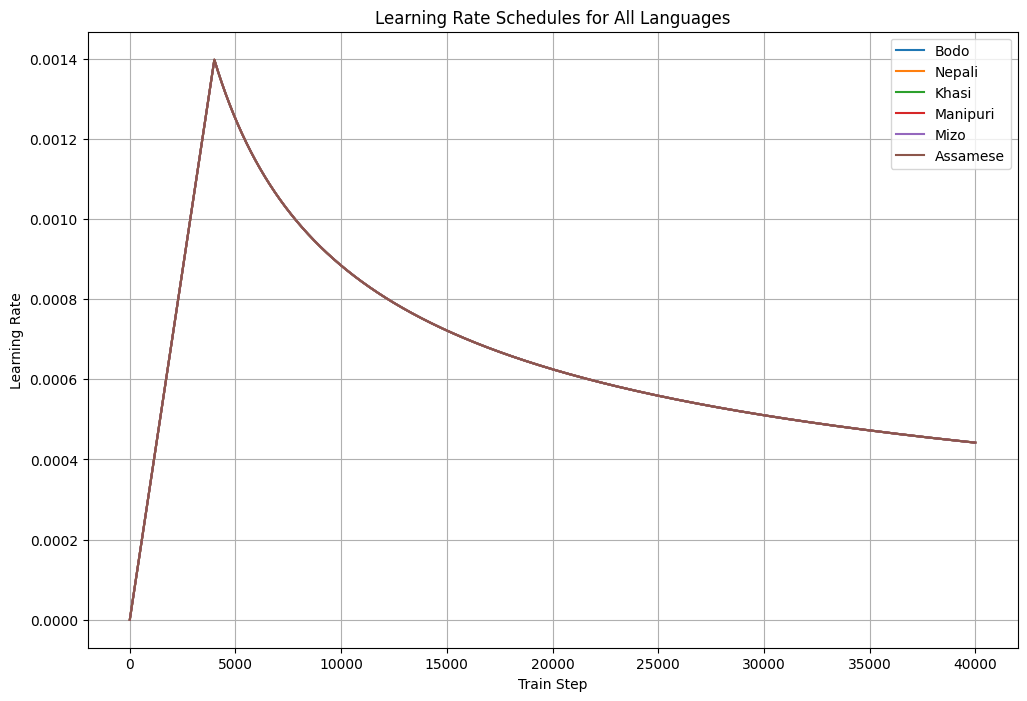

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Create custom learning rate schedules for all language pairs
learning_rate_schedule_bodo = CustomSchedule(d_model)
learning_rate_schedule_nepali = CustomSchedule(d_model)
learning_rate_schedule_khasi = CustomSchedule(d_model)
learning_rate_schedule_manipuri = CustomSchedule(d_model)
learning_rate_schedule_mizo = CustomSchedule(d_model)
learning_rate_schedule_assamese = CustomSchedule(d_model)

# Define a function to plot all learning rate schedules on a single graph
def plot_all_learning_rate_schedules(schedules, labels, num_steps=40000):
    plt.figure(figsize=(12, 8))

    for schedule, label in zip(schedules, labels):
        plt.plot(tf.range(num_steps, dtype=tf.float32), schedule(tf.range(num_steps, dtype=tf.float32)), label=label)

    plt.title("Learning Rate Schedules for All Languages")
    plt.xlabel("Train Step")
    plt.ylabel("Learning Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

# Create a list of schedules and labels
schedules = [
    learning_rate_schedule_bodo,
    learning_rate_schedule_nepali,
    learning_rate_schedule_khasi,
    learning_rate_schedule_manipuri,
    learning_rate_schedule_mizo,
    learning_rate_schedule_assamese
]

labels = [
    "Bodo",
    "Nepali",
    "Khasi",
    "Manipuri",
    "Mizo",
    "Assamese"
]

# Plot all learning rate schedules on a single graph
plot_all_learning_rate_schedules(schedules, labels)


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
# Define the MultiTransformer class with separate parameters for each decoder
class MultiTransformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, encoder_vocab_size,
                 decoder_bodo_vocab_size, decoder_nepali_vocab_size,
                 decoder_khasi_vocab_size, decoder_manipuri_vocab_size,
                 decoder_mizo_vocab_size, decoder_assamese_vocab_size,
                 pe_input, pe_target, rate):
        super(MultiTransformer, self).__init__()
        # Initialize encoder and decoders
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, encoder_vocab_size, pe_input, rate)
        self.decoder_bodo = Decoder(num_layers, d_model, num_heads, dff, decoder_bodo_vocab_size, pe_target, rate)
        self.decoder_nepali = Decoder(num_layers, d_model, num_heads, dff, decoder_nepali_vocab_size, pe_target, rate)
        self.decoder_khasi = Decoder(num_layers, d_model, num_heads, dff, decoder_khasi_vocab_size, pe_target, rate)
        self.decoder_manipuri = Decoder(num_layers, d_model, num_heads, dff, decoder_manipuri_vocab_size, pe_target, rate)
        self.decoder_mizo = Decoder(num_layers, d_model, num_heads, dff, decoder_mizo_vocab_size, pe_target, rate)
        self.decoder_assamese = Decoder(num_layers, d_model, num_heads, dff, decoder_assamese_vocab_size, pe_target, rate)

    def call(self, inputs, targets):
        # Process the inputs through the encoder and each decoder
        encoder_output = self.encoder(inputs)
        decoder_bodo_output = self.decoder_bodo(targets['bodo'], encoder_output)
        decoder_nepali_output = self.decoder_nepali(targets['nepali'], encoder_output)
        decoder_khasi_output = self.decoder_khasi(targets['khasi'], encoder_output)
        decoder_manipuri_output = self.decoder_manipuri(targets['manipuri'], encoder_output)
        decoder_mizo_output = self.decoder_mizo(targets['mizo'], encoder_output)
        decoder_assamese_output = self.decoder_assamese(targets['assamese'], encoder_output)

        return decoder_bodo_output, decoder_nepali_output, decoder_khasi_output, decoder_manipuri_output, decoder_mizo_output, decoder_assamese_output

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


In [ ]:

# Define the train_step function
@tf.function
def train_step(inp_bodo, inp_nepali, tar_bodo, tar_nepali, mask_bodo=None, mask_nepali=None):
    # ... (rest of the function remains the same)

    # Define masks for language pair Bodo
    tar_inp_bodo = tar_bodo[:, :-1]
    tar_real_bodo = tar_bodo[:, 1:]
    enc_padding_mask_bodo, combined_mask_bodo, dec_padding_mask_bodo = create_masks(inp_bodo, tar_inp_bodo)

    # Define masks for language pair Nepali
    if tar_nepali is not None:
        tar_inp_nepali = tar_nepali[:, :-1]
        tar_real_nepali = tar_nepali[:, 1:]
        enc_padding_mask_nepali, combined_mask_nepali, dec_padding_mask_nepali = create_masks(inp_nepali, tar_inp_nepali)

    with tf.GradientTape(persistent=True) as tape:
        # Get predictions for language pair Bodo
        predictions_bodo, _, _, _ = multi_transformer(
            inp_bodo, inp_nepali, tar_inp_bodo, tar_inp_nepali,
            True, enc_padding_mask_bodo, combined_mask_bodo, dec_padding_mask_bodo,
            enc_padding_mask_nepali, combined_mask_nepali, dec_padding_mask_nepali
        )

        # Calculate loss for language pair Bodo
        loss_bodo = loss_function(tar_real_bodo, predictions_bodo)

        # Calculate loss for language pair Nepali if tar_nepali is not None
        if tar_nepali is not None:
            predictions_nepali, _, _, _ = multi_transformer(
                inp_bodo, inp_nepali, tar_inp_bodo, tar_inp_nepali,
                True, enc_padding_mask_bodo, combined_mask_bodo, dec_padding_mask_bodo,
                enc_padding_mask_nepali, combined_mask_nepali, dec_padding_mask_nepali
            )
            loss_nepali = loss_function(tar_real_nepali, predictions_nepali)
            total_loss = loss_bodo + loss_nepali
        else:
            total_loss = loss_bodo

    # Calculate gradients and apply them using the optimizer
    gradients = tape.gradient(total_loss, multi_transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, multi_transformer.trainable_variables))

    # Update metrics
    train_loss(total_loss)
    train_accuracy(accuracy_function(tar_real_bodo, predictions_bodo))

# Define train_loss and train_accuracy
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')



### English to Indic Example


In [ ]:

en_sents = [
    "He was a king too.",
    "He slept the whole night.",
    "They have failed.",
    "Open a new browser.",
    "he wrote well in the examination ",
    "You must specify a file name",
]


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir, "en-indic", quantization)

ip = IndicProcessor(inference=True)


src_lang, tgt_lang = "eng_Latn", "asm_Beng"
asm_translations = batch_translate(en_sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
print("------------------------------------------------")

for input_sentence, translation in zip(en_sents, asm_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")
    asm_translations = {translation}
    # Print the output list (for demonstration)
    print("------------------------------------------------")

# flush the models to free the GPU memory
del en_indic_tokenizer, en_indic_model


eng_Latn - asm_Beng
------------------------------------------------
eng_Latn: He was a king too.
asm_Beng: তেওঁ এজন ৰজাও আছিল।
------------------------------------------------
eng_Latn: He slept the whole night.
asm_Beng: গোটেই ৰাতি তেওঁ শুই আছিল।
------------------------------------------------
eng_Latn: They have failed.
asm_Beng: তেওঁলোক বিফল হৈছিল।
------------------------------------------------
eng_Latn: Open a new browser.
asm_Beng: এটা নতুন ব্ৰাউজাৰ খোলক।
------------------------------------------------
eng_Latn: he wrote well in the examination 
asm_Beng: তেওঁ পৰীক্ষাত ভালদৰে লিখিছিল
------------------------------------------------
eng_Latn: You must specify a file name
asm_Beng: আপুনি এটা ফাইলৰ নাম উল্লেখ কৰিব লাগিব
------------------------------------------------


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir, "en-indic", quantization)

ip = IndicProcessor(inference=True)


src_lang, tgt_lang = "eng_Latn", "brx_Deva"
brx_translations = batch_translate(en_sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
print("------------------------------------------------")

for input_sentence, translation in zip(en_sents, brx_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")
    brx_translations = {translation}
    # Print the output list (for demonstration)
    print("------------------------------------------------")

# flush the models to free the GPU memory
del en_indic_tokenizer, en_indic_model


eng_Latn - brx_Deva
------------------------------------------------
eng_Latn: He was a king too.
brx_Deva: बियो सासे राजाबोमोन।
------------------------------------------------
eng_Latn: He slept the whole night.
brx_Deva: बियो गासै हरावनो उन्दुदोंमोन।
------------------------------------------------
eng_Latn: They have failed.
brx_Deva: बिसोर फेलें जाबाय।
------------------------------------------------
eng_Latn: Open a new browser.
brx_Deva: मोनसे गोदान ब्राउजार खेव।
------------------------------------------------
eng_Latn: he wrote well in the examination 
brx_Deva: बियो आनजादयाव मोजाङै लिरदोंमोन।
------------------------------------------------
eng_Latn: You must specify a file name
brx_Deva: नों मोनसे फाइलनि मुंखौ थि खालामथारनांगोन।
------------------------------------------------


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir, "en-indic", quantization)

ip = IndicProcessor(inference=True)


src_lang, tgt_lang = "eng_Latn", "npi_Deva"
npi_translations = batch_translate(en_sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
print("------------------------------------------------")
for input_sentence, translation in zip(en_sents, npi_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")
    npi_translations = {translation}
    # Print the output list (for demonstration)
    print("------------------------------------------------")

# flush the models to free the GPU memory
del en_indic_tokenizer, en_indic_model


eng_Latn - npi_Deva
------------------------------------------------
eng_Latn: He was a king too.
npi_Deva: उनी पनि राजा थिए।
------------------------------------------------
eng_Latn: He slept the whole night.
npi_Deva: उनी रातभरि सुतिरहेका थिए।
------------------------------------------------
eng_Latn: They have failed.
npi_Deva: तिनीहरू असफल भएका छन्।
------------------------------------------------
eng_Latn: Open a new browser.
npi_Deva: नयाँ ब्राउजर खोल्नुहोस्।
------------------------------------------------
eng_Latn: he wrote well in the examination 
npi_Deva: उनले परीक्षामा राम्रो लेखे।
------------------------------------------------
eng_Latn: You must specify a file name
npi_Deva: तपाईँले फाइलको नाम निर्दिष्ट गर्नुपर्छ
------------------------------------------------


In [ ]:
# Assuming ekha is imported and has the khasi_translate function
import ekha


# Function to generate list of formatted translations
def khasi_output(eng_sents):
    output = []
    for sentence in eng_sents:
        khasi_translation = ekha.khasi_translate(sentence)  # Use ekha's translation function
        output.append(f"eng_Latn: {sentence}")
        output.append(f"kha_Latn: {khasi_translation}")
        output.append("")  # Add a blank line for separation
    return output

# Get the output list
output_list = khasi_output(en_sents)

# Print the output list (for demonstration)
for line in output_list:
    print(line)

eng_Latn: He was a king too.
kha_Latn: u syiem u la pynlut haduh snem

eng_Latn: He slept the whole night.
kha_Latn: u thiah mynmiet u thiah shimiet

eng_Latn: They have failed.
kha_Latn: hato kim don umjer nangno ki ing kim don jingbam

eng_Latn: Open a new browser.
kha_Latn: plie ki jingduwai bathymmai

eng_Latn: he wrote well in the examination 
kha_Latn: u thoh bha bha ha ka examination

eng_Latn: You must specify a file name
kha_Latn: ka jingbhabriew ka dei ka maakah ka ingbishar



In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir, "en-indic", quantization)

ip = IndicProcessor(inference=True)


src_lang, tgt_lang = "eng_Latn", "mni_Beng"
mni_translations = batch_translate(en_sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
print("------------------------------------------------")
for input_sentence, translation in zip(en_sents, mni_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")
    mni_translations = {translation}
    # Print the output list (for demonstration)
    print("------------------------------------------------")

# flush the models to free the GPU memory
del en_indic_tokenizer, en_indic_model


eng_Latn - mni_Beng
------------------------------------------------
eng_Latn: He was a king too.
mni_Beng: মহাক এপার্থিদকী মায়োক্তা লৈবা এক্তিবিস্ত অমনি।
------------------------------------------------
eng_Latn: He slept the whole night.
mni_Beng: নুমিদাং ফাওবা অসুম অসুম থেঙজিল্লক্লি।
------------------------------------------------
eng_Latn: They have failed.
mni_Beng: অদুবু মখোয়না খঙদবা হায়বসি য়াম্না লাইবক থিবা অমনি।
------------------------------------------------
eng_Latn: Open a new browser.
mni_Beng: অনৌবা পেজ অমা হাপচিনবা
------------------------------------------------
eng_Latn: he wrote well in the examination 
mni_Beng: মহাক্না চাংয়েং অদুদা নীংথিনা ইখি।
------------------------------------------------
eng_Latn: You must specify a file name
mni_Beng: অদোম্না ফাইল অমগী মমিং পীবা তাই।
------------------------------------------------


In [ ]:
# Assuming elus is imported and has the mizo_translate function
import elus


# Function to generate list of formatted translations for Mizo
def mizo_output(eng_sents):
    output = []
    for sentence in eng_sents:
        mizo_translation = elus.mizo_translate(sentence)  # Use elus's translation function
        output.append(f"eng_Latn: {sentence}")
        output.append(f"mizo_Latn: {mizo_translation}")
        output.append("")  # Add a blank line for separation
    return output

# Get the output list
output_list_mizo = mizo_output(en_sents)

# Print the output list (for demonstration)
for line in output_list_mizo:
    print(line)


eng_Latn: He was a king too.
mizo_Latn: lal a ni

eng_Latn: He slept the whole night.
mizo_Latn: zan khat chu a mu

eng_Latn: They have failed.
mizo_Latn: an nei lo

eng_Latn: Open a new browser.
mizo_Latn: sum thar thawk thar

eng_Latn: he wrote well in the examination 
mizo_Latn: a tha khawp mai

eng_Latn: You must specify a file name
mizo_Latn: lalber chuan ani chu tihhlum a ni dwn tih tu nge a tiam a



# **Evaluation Metrics**

In [ ]:
!pip install pyter3
!pip install sacrebleu
!pip install rouge_score
import nltk
nltk.download('punkt')  # Download the Punkt tokenizer
nltk.download('wordnet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=bc5415847a0edb68b3ac0737ed73b846a343084387102fb4420fbee4a3952e3c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import csv
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Load actual translations from actual.csv
with open('/content/drive/MyDrive//multilingual/eng_to_indic/as/actual_assamese.csv', 'r') as file:
    actual_reader = csv.reader(file)
    actual_translations = [row[0].split() for row in actual_reader]

# Load predicted translations from predicted.csv
with open('/content/drive/MyDrive//multilingual/eng_to_indic/as/prediction_assamese.csv', 'r') as file:
    predicted_reader = csv.reader(file)
    predicted_translations = [row[0].split() for row in predicted_reader]

# Define a smoothing function for BLEU score calculation
smoothie = SmoothingFunction().method1

# Compute BLEU score for corpus level with smoothing
corpus_score = corpus_bleu(actual_translations, predicted_translations, smoothing_function=smoothie)

# Compute BLEU score for sentence level with smoothing
sentence_scores = [sentence_bleu([actual], predicted, smoothing_function=smoothie) for actual, predicted in zip(actual_translations, predicted_translations)]

# Calculate average sentence level BLEU score
avg_sentence_score = sum(sentence_scores) / len(sentence_scores)

# Print the scores
# print("Corpus BLEU score:", corpus_score)
print("Assamese BLEU score:", avg_sentence_score)


Assamese BLEU score: 0.2795884109211922


In [ ]:
import pandas as pd
import sacrebleu
from nltk.translate.bleu_score import corpus_bleu

# Load reference and prediction CSV files
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/as/actual_assamese.csv'
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/as/prediction_assamese.csv'

reference_df = pd.read_csv(reference_file)
prediction_df = pd.read_csv(prediction_file)


references = reference_df['ASSAMESE'].tolist()
predictions = prediction_df['ASSAMESE'].tolist()

# Calculate SacreBLEU score
sacrebleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
print(f"Assamese SacreBLEU Score: {sacrebleu_score/100}")



Assamese SacreBLEU Score: 0.240036184434208


In [ ]:
import csv
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize


# File paths
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/as/actual_assamese.csv'  # Path to the CSV file containing reference Nepali translations
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/as/prediction_assamese.csv'  # Path to the CSV file containing model's predicted Nepali translations

# Initialize lists to hold reference and predicted sentences
references = []
predictions = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the reference sentence
        references.append(word_tokenize(row[0]))  # Assuming the reference text is in the first column

# Read model predictions from CSV file
with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the prediction sentence
        predictions.append(word_tokenize(row[0]))  # Assuming the prediction text is in the first column

# Ensure references and predictions have the same length
assert len(references) == len(predictions), "References and predictions must have the same length"

# Calculate the METEOR score for each pair of reference and prediction
total_meteor_score = 0.0
num_sentences = len(references)

for ref, pred in zip(references, predictions):
    score = meteor_score([ref], pred)
    total_meteor_score += score

# Calculate the average METEOR score
avg_meteor_score = total_meteor_score / num_sentences

print(f"Assamese METEOR Score: {avg_meteor_score:.4f}")

Assamese METEOR Score: 0.4123


In [ ]:
import csv
from rouge_score import rouge_scorer

# Initialize a ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# File paths
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/as/actual_assamese.csv'  # Path to the CSV file containing reference Nepali translations
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/as/prediction_assamese.csv'  # Path to the CSV file containing model's predicted Nepali translations

# Initialize lists to hold ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    references = [row[0] for row in reader]

with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    predictions = [row[0] for row in reader]

# Calculate the ROUGE scores for each pair of reference and prediction
for ref, pred in zip(references, predictions):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)


print(f"Assamese ROUGE Score: {avg_rouge1:.4f}")
#print(f"Assamese ROUGE Score: {avg_rouge2:.4f}")
#print(f"ROUGE-L Score: {avg_rougeL:.4f}")


Assamese ROUGE Score: 0.1467
Assamese ROUGE Score: 0.0400


In [ ]:
import pyter
reference_as_file = '/content/drive/MyDrive//multilingual/eng_to_indic/as/actual_assamese.csv'
hypothesis_as_file = '/content/drive/MyDrive//multilingual/eng_to_indic/as/prediction_assamese.csv'
ter_score = pyter.ter(reference_as_file, hypothesis_as_file)
print(f"TER Assamese Score: {ter_score}")

TER Assamese Score: 0.10526315789473684


# **Bodo**

In [ ]:
import csv
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Load actual translations from actual.csv
with open('/content/drive/MyDrive//multilingual/eng_to_indic/brx/actual.csv', 'r') as file:
    actual_reader = csv.reader(file)
    actual_translations = [row[0].split() for row in actual_reader]

# Load predicted translations from predicted.csv
with open('/content/drive/MyDrive//multilingual/eng_to_indic/brx/prediction_bodo.csv', 'r') as file:
    predicted_reader = csv.reader(file)
    predicted_translations = [row[0].split() for row in predicted_reader]

# Define a smoothing function for BLEU score calculation
smoothie = SmoothingFunction().method1

# Compute BLEU score for corpus level with smoothing
corpus_score = corpus_bleu(actual_translations, predicted_translations, smoothing_function=smoothie)

# Compute BLEU score for sentence level with smoothing
sentence_scores = [sentence_bleu([actual], predicted, smoothing_function=smoothie) for actual, predicted in zip(actual_translations, predicted_translations)]

# Calculate average sentence level BLEU score
avg_sentence_score = sum(sentence_scores) / len(sentence_scores)

# Print the scores
# print("Corpus BLEU score:", corpus_score)
print("Bodo BLEU score:", avg_sentence_score)


Bodo BLEU score: 0.24187137243578544


In [ ]:
import pandas as pd
import sacrebleu
from nltk.translate.bleu_score import corpus_bleu

# Load reference and prediction CSV files
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/brx/actual.csv'
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/brx/prediction_bodo.csv'

reference_df = pd.read_csv(reference_file)
prediction_df = pd.read_csv(prediction_file)


references = reference_df['BODO'].tolist()
predictions = prediction_df['BODO'].tolist()

# Calculate SacreBLEU score
sacrebleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
print(f" Bodo SacreBLEU Score: {sacrebleu_score/100}")



 Bodo SacreBLEU Score: 0.17077413927287693


In [ ]:
import csv
from rouge_score import rouge_scorer

# Initialize a ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# File paths
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/brx/actual.csv'  # Path to the CSV file containing reference Nepali translations
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/brx/prediction_bodo.csv'  # Path to the CSV file containing model's predicted Nepali translations

# Initialize lists to hold ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    references = [row[0] for row in reader]

with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    predictions = [row[0] for row in reader]

# Calculate the ROUGE scores for each pair of reference and prediction
for ref, pred in zip(references, predictions):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) *10/ len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) *10/ len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) *10 / len(rougeL_scores)
# print("")
#print(f" ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Bodo  ROUGE Score: {avg_rouge2:.4f}")
# print(f" ROUGE-L Score: {avg_rougeL:.4f}")

Bodo  ROUGE Score: 0.1231


In [ ]:
import csv
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize



# File paths
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/brx/actual.csv'  # Path to the CSV file containing reference Nepali translations
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/brx/prediction_bodo.csv'  # Path to the CSV file containing model's predicted Nepali translations

# Initialize lists to hold reference and predicted sentences
references = []
predictions = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the reference sentence
        references.append(word_tokenize(row[0]))  # Assuming the reference text is in the first column

# Read model predictions from CSV file
with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the prediction sentence
        predictions.append(word_tokenize(row[0]))  # Assuming the prediction text is in the first column

# Ensure references and predictions have the same length
assert len(references) == len(predictions), "References and predictions must have the same length"

# Calculate the METEOR score for each pair of reference and prediction
total_meteor_score = 0.0
num_sentences = len(references)

for ref, pred in zip(references, predictions):
    score = meteor_score([ref], pred)
    total_meteor_score += score

# Calculate the average METEOR score
avg_meteor_score = total_meteor_score / num_sentences

print(f"Bodo METEOR Score: {avg_meteor_score:.4f}")

Bodo METEOR Score: 0.3098


In [ ]:
import pyter
reference_brx_file = '/content/drive/MyDrive//multilingual/eng_to_indic/brx/actual_bodo.csv'
hypothesis_brx_file = '/content/drive/MyDrive//multilingual/eng_to_indic/brx/prediction_bodo.csv'
ter_score = pyter.ter(reference_brx_file, hypothesis_brx_file)
print(f"TER Bodo Score: {ter_score}")

TER Bodo Score: 0.1095890410958904


# **Khasi**

In [ ]:
import csv
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Load actual translations from actual.csv
with open('/content/drive/MyDrive//multilingual/eng_to_indic/kha/actual_khasi.csv', 'r') as file:
    actual_reader = csv.reader(file)
    actual_translations = [row[0].split() for row in actual_reader]

# Load predicted translations from predicted.csv
with open('/content/drive/MyDrive//multilingual/eng_to_indic/kha/prediction_khasi.csv', 'r') as file:
    predicted_reader = csv.reader(file)
    predicted_translations = [row[0].split() for row in predicted_reader]

# Define a smoothing function for BLEU score calculation
smoothie = SmoothingFunction().method1

# Compute BLEU score for corpus level with smoothing
corpus_score = corpus_bleu(actual_translations, predicted_translations, smoothing_function=smoothie)

# Compute BLEU score for sentence level with smoothing
sentence_scores = [sentence_bleu([actual], predicted, smoothing_function=smoothie) for actual, predicted in zip(actual_translations, predicted_translations)]

# Calculate average sentence level BLEU score
avg_sentence_score = sum(sentence_scores) / len(sentence_scores)

# Print the scores
# print("Corpus BLEU score:", corpus_score)
print("Khasi BLEU score:", avg_sentence_score)


Khasi BLEU score: 0.10968701661703499


In [ ]:
import pandas as pd
import sacrebleu
from nltk.translate.bleu_score import corpus_bleu

# Load reference and prediction CSV files
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/kha/actual_khasi.csv'
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/kha/prediction_khasi.csv'

reference_df = pd.read_csv(reference_file)
prediction_df = pd.read_csv(prediction_file)


references = reference_df['KHASI'].tolist()
predictions = prediction_df['KHASI'].tolist()

# Calculate SacreBLEU score
sacrebleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
print(f"Khasi SacreBLEU Score: {sacrebleu_score/100}")



Khasi SacreBLEU Score: 0.14372333610745275


In [ ]:
import csv
from rouge_score import rouge_scorer

# Initialize a ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)


# Load actual and prediction data from CSV files
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/kha/actual_khasi.csv'
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/kha/prediction_khasi.csv'

# Initialize lists to hold ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    references = [row[0] for row in reader]

with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    predictions = [row[0] for row in reader]

# Calculate the ROUGE scores for each pair of reference and prediction
for ref, pred in zip(references, predictions):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)


# print(f"ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Khasi ROUGE Score: {avg_rouge2:.4f}")
# print(f"ROUGE-L Score: {avg_rougeL:.4f}")


Khasi ROUGE Score: 0.1967


In [ ]:
import csv
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize


# Load actual and prediction data from CSV files
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/kha/actual_khasi.csv'
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/kha/prediction_khasi.csv'

# Initialize lists to hold reference and predicted sentences
references = []
predictions = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the reference sentence
        references.append(word_tokenize(row[0]))  # Assuming the reference text is in the first column

# Read model predictions from CSV file
with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the prediction sentence
        predictions.append(word_tokenize(row[0]))  # Assuming the prediction text is in the first column

# Ensure references and predictions have the same length
assert len(references) == len(predictions), "References and predictions must have the same length"

# Calculate the METEOR score for each pair of reference and prediction
total_meteor_score = 0.0
num_sentences = len(references)

for ref, pred in zip(references, predictions):
    score = meteor_score([ref], pred)
    total_meteor_score += score

# Calculate the average METEOR score
avg_meteor_score = total_meteor_score / num_sentences

print(f"Khasi METEOR Score: {avg_meteor_score:.4f}")

Khasi METEOR Score: 0.3308


In [ ]:
import pyter
reference_kha_file = '/content/drive/MyDrive//multilingual/eng_to_indic/kha/actual_khasi.csv'
hypothesis_kha_file = '/content/drive/MyDrive//multilingual/eng_to_indic/kha/prediction_khasi.csv'
ter_score = pyter.ter(reference_kha_file, hypothesis_kha_file)
print(f"TER Khasi Score: {ter_score}")

TER Khasi Score: 0.10810810810810811


# **Manipuri**

In [ ]:
import csv
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Load actual translations from actual.csv
with open('/content/drive/MyDrive/multilingual/eng_to_indic/mni/actual.csv', 'r') as file:
    actual_reader = csv.reader(file)
    actual_translations = [row[0].split() for row in actual_reader]

# Load predicted translations from predicted.csv
with open('/content/drive/MyDrive//multilingual/eng_to_indic/mni/prediction.csv', 'r') as file:
    predicted_reader = csv.reader(file)
    predicted_translations = [row[0].split() for row in predicted_reader]

# Define a smoothing function for BLEU score calculation
smoothie = SmoothingFunction().method1

# Compute BLEU score for corpus level with smoothing
corpus_score = corpus_bleu(actual_translations, predicted_translations, smoothing_function=smoothie)

# Compute BLEU score for sentence level with smoothing
sentence_scores = [sentence_bleu([actual], predicted, smoothing_function=smoothie) for actual, predicted in zip(actual_translations, predicted_translations)]

# Calculate average sentence level BLEU score
avg_sentence_score = sum(sentence_scores) / len(sentence_scores)

# Print the scores
# print("Corpus BLEU score:", corpus_score)
print("Manipuri BLEU score:", avg_sentence_score)


Manipuri BLEU score: 0.11534257897289453


In [ ]:
import pandas as pd
import sacrebleu
from nltk.translate.bleu_score import corpus_bleu

# Load reference and prediction CSV files
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/mni/actual.csv'
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/mni/prediction.csv'

reference_df = pd.read_csv(reference_file)
prediction_df = pd.read_csv(prediction_file)


references = reference_df['MANIPURI'].tolist()
predictions = prediction_df['MANIPURI'].tolist()

# Calculate SacreBLEU score
sacrebleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
print(f" Manipuri SacreBLEU Score: {sacrebleu_score/100}")



 Manipuri SacreBLEU Score: 0.13559250020888106


In [ ]:
import csv
from rouge_score import rouge_scorer

# Initialize a ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Load reference and prediction CSV files
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/mni/actual.csv'
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/mni/prediction.csv'
# Initialize lists to hold ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    references = [row[0] for row in reader]

with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    predictions = [row[0] for row in reader]

# Calculate the ROUGE scores for each pair of reference and prediction
for ref, pred in zip(references, predictions):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) *10/ len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) *10/ len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) *10 / len(rougeL_scores)

# print(f" ROUGE-1 Score: {avg_rouge1:.4f}")
print(f" Manipuri ROUGE Score: {avg_rouge2:.4f}")
# print(f" ROUGE-L Score: {avg_rougeL:.4f}")

 Manipuri ROUGE Score: 0.2439


In [ ]:
import csv
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize



## Load reference and prediction CSV files
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/mni/actual.csv'
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/mni/prediction.csv'
# Initialize lists to hold reference and predicted sentences
references = []
predictions = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the reference sentence
        references.append(word_tokenize(row[0]))  # Assuming the reference text is in the first column

# Read model predictions from CSV file
with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the prediction sentence
        predictions.append(word_tokenize(row[0]))  # Assuming the prediction text is in the first column

# Ensure references and predictions have the same length
assert len(references) == len(predictions), "References and predictions must have the same length"

# Calculate the METEOR score for each pair of reference and prediction
total_meteor_score = 0.0
num_sentences = len(references)

for ref, pred in zip(references, predictions):
    score = meteor_score([ref], pred)
    total_meteor_score += score

# Calculate the average METEOR score
avg_meteor_score = total_meteor_score / num_sentences

print(f"Manipuri METEOR Score: {avg_meteor_score:.4f}")

Manipuri METEOR Score: 0.2454


In [ ]:
import pyter
reference_mni_file = '/content/drive/MyDrive//multilingual/eng_to_indic/mni/actual.csv'
hypothesis_mni_file = '/content/drive/MyDrive//multilingual/eng_to_indic/mni/prediction.csv'
ter_score = pyter.ter(reference_mni_file, hypothesis_mni_file)
print(f"TER Manipuri Score: {ter_score}")

TER Manipuri Score: 0.11764705882352941


# **Mizo**

In [ ]:
import csv
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Load actual translations from actual.csv
with open('/content/drive/MyDrive/multilingual/eng_to_indic/lus/actual_mizo.csv', 'r') as file:
    actual_reader = csv.reader(file)
    actual_translations = [row[0].split() for row in actual_reader]

# Load predicted translations from predicted.csv
with open('/content/drive/MyDrive//multilingual/eng_to_indic/lus/prediction_mizo.csv', 'r') as file:
    predicted_reader = csv.reader(file)
    predicted_translations = [row[0].split() for row in predicted_reader]

# Define a smoothing function for BLEU score calculation
smoothie = SmoothingFunction().method1

# Compute BLEU score for corpus level with smoothing
corpus_score = corpus_bleu(actual_translations, predicted_translations, smoothing_function=smoothie)

# Compute BLEU score for sentence level with smoothing
sentence_scores = [sentence_bleu([actual], predicted, smoothing_function=smoothie) for actual, predicted in zip(actual_translations, predicted_translations)]

# Calculate average sentence level BLEU score
avg_sentence_score = sum(sentence_scores) / len(sentence_scores)

# Print the scores
# print("Corpus BLEU score:", corpus_score)
print("Mizo BLEU score:", avg_sentence_score)


Mizo BLEU score: 0.1236120938142832


In [ ]:
import pandas as pd
import sacrebleu
from nltk.translate.bleu_score import corpus_bleu

# Load reference and prediction CSV files
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/lus/actual_mizo.csv'
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/lus/prediction_mizo.csv'

reference_df = pd.read_csv(reference_file)
prediction_df = pd.read_csv(prediction_file)


references = reference_df['MIZO'].tolist()
predictions = prediction_df['MIZO'].tolist()

# Calculate SacreBLEU score
sacrebleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
print(f"Mizo SacreBLEU Score: {sacrebleu_score}")



Mizo SacreBLEU Score: 14.511023703400175


In [ ]:
# Load actual and prediction data from CSV files
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/lus/actual_mizo.csv'
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/lus/prediction_mizo.csv'

# Initialize lists to hold reference and predicted sentences
references = []
predictions = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the reference sentence
        references.append(word_tokenize(row[0]))  # Assuming the reference text is in the first column

# Read model predictions from CSV file
with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the prediction sentence
        predictions.append(word_tokenize(row[0]))  # Assuming the prediction text is in the first column

# Ensure references and predictions have the same length
assert len(references) == len(predictions), "References and predictions must have the same length"

# Calculate the METEOR score for each pair of reference and prediction
total_meteor_score = 0.0
num_sentences = len(references)

for ref, pred in zip(references, predictions):
    score = meteor_score([ref], pred)
    total_meteor_score += score

# Calculate the average METEOR score
avg_meteor_score = total_meteor_score / num_sentences

print(f"Mizo METEOR Score: {avg_meteor_score:.4f}")

Mizo METEOR Score: 0.2743


In [ ]:
import csv
from rouge_score import rouge_scorer

# Initialize a ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)


# Load actual and prediction data from CSV files
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/lus/actual_mizo.csv'
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/lus/prediction_mizo.csv'

# Initialize lists to hold ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    references = [row[0] for row in reader]

with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    predictions = [row[0] for row in reader]

# Calculate the ROUGE scores for each pair of reference and prediction
for ref, pred in zip(references, predictions):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

#print(f"ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Mizo ROUGE Score: {avg_rouge2:.4f}")
# print(f"ROUGE-L Score: {avg_rougeL:.4f}")


Mizo ROUGE Score: 0.1618


In [ ]:
import pyter
reference_lus_file = '/content/drive/MyDrive//multilingual/eng_to_indic/lus/actual_mizo.csv'
hypothesis_lus_file = '/content/drive/MyDrive//multilingual/eng_to_indic/lus/prediction_mizo.csv'
ter_score = pyter.ter(reference_lus_file, hypothesis_lus_file)
print(f"TER Mizo Score: {ter_score}")

TER Mizo Score: 0.1095890410958904


# **Nepali**

In [ ]:
import csv
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Load actual translations from actual.csv
with open('/content/drive/MyDrive//multilingual/eng_to_indic/npi/actual.csv', 'r') as file:
    actual_reader = csv.reader(file)
    actual_translations = [row[0].split() for row in actual_reader]

# Load predicted translations from predicted.csv
with open('/content/drive/MyDrive//multilingual/eng_to_indic/npi/prediction_nepali.csv', 'r') as file:
    predicted_reader = csv.reader(file)
    predicted_translations = [row[0].split() for row in predicted_reader]

# Define a smoothing function for BLEU score calculation
smoothie = SmoothingFunction().method1

# Compute BLEU score for corpus level with smoothing
corpus_score = corpus_bleu(actual_translations, predicted_translations, smoothing_function=smoothie)

# Compute BLEU score for sentence level with smoothing
sentence_scores = [sentence_bleu([actual], predicted, smoothing_function=smoothie) for actual, predicted in zip(actual_translations, predicted_translations)]

# Calculate average sentence level BLEU score
avg_sentence_score = sum(sentence_scores) / len(sentence_scores)

# Print the scores
# print("Corpus BLEU score:", corpus_score)
print("Nepali BLEU score:", avg_sentence_score)


Nepali BLEU score: 0.3100018077218886


In [ ]:
import pandas as pd
import sacrebleu
from nltk.translate.bleu_score import corpus_bleu

# Load reference and prediction CSV files
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/npi/actual.csv'
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/npi/prediction_nepali.csv'

reference_df = pd.read_csv(reference_file)
prediction_df = pd.read_csv(prediction_file)



references = reference_df['NEPALI'].tolist()
predictions = prediction_df['NEPALI'].tolist()

# Calculate SacreBLEU score
sacrebleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
print(f"SacreBLEU Score: {sacrebleu_score}")


SacreBLEU Score: 30.70280451518892


In [ ]:
import csv
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize


# File paths
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/npi/actual.csv'  # Path to the CSV file containing reference Nepali translations
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/npi/prediction_nepali.csv'  # Path to the CSV file containing model's predicted Nepali translations

# Initialize lists to hold reference and predicted sentences
references = []
predictions = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the reference sentence
        references.append(word_tokenize(row[0]))  # Assuming the reference text is in the first column

# Read model predictions from CSV file
with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the prediction sentence
        predictions.append(word_tokenize(row[0]))  # Assuming the prediction text is in the first column

# Ensure references and predictions have the same length
assert len(references) == len(predictions), "References and predictions must have the same length"

# Calculate the METEOR score for each pair of reference and prediction
total_meteor_score = 0.0
num_sentences = len(references)

for ref, pred in zip(references, predictions):
    score = meteor_score([ref], pred)
    total_meteor_score += score

# Calculate the average METEOR score
avg_meteor_score = total_meteor_score / num_sentences

print(f"Nepali METEOR Score: {avg_meteor_score:.4f}")

Nepali METEOR Score: 0.3593


In [ ]:
import csv
from rouge_score import rouge_scorer

# Initialize a ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# File paths
reference_file = '/content/drive/MyDrive//multilingual/eng_to_indic/npi/actual.csv'  # Path to the CSV file containing reference Nepali translations
prediction_file = '/content/drive/MyDrive//multilingual/eng_to_indic/npi/prediction_nepali.csv'  # Path to the CSV file containing model's predicted Nepali translations

# Initialize lists to hold ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    references = [row[0] for row in reader]

with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    predictions = [row[0] for row in reader]

# Calculate the ROUGE scores for each pair of reference and prediction
for ref, pred in zip(references, predictions):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) *10/ len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) *10/ len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) *10 / len(rougeL_scores)


# print(f"ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Nepali ROUGE Score: {avg_rouge2:.4f}")
# print(f"ROUGE-L Score: {avg_rougeL:.4f}")

Nepali ROUGE Score: 0.1000


In [ ]:
import pyter
reference_npi_file = '/content/drive/MyDrive//multilingual/eng_to_indic/npi/actual.csv'
hypothesis_npi_file = '/content/drive/MyDrive//multilingual/eng_to_indic/npi/prediction_nepali.csv'
ter_score = pyter.ter(reference_npi_file, hypothesis_npi_file)
print(f"TER Nepali Score: {ter_score}")

TER Nepali Score: 0.17333333333333334
